 Autora: Mariana Belloube
 ### Desafio de Machine Learning para monitoramento de veículos de carga: Protótipo Matrix Tracking


**1. O Desafio:**
  * Desenvolver código em Python para o desafio **CE263N Assignment 4** da plataforma Kaggle.
  * Desenvolver e validar um protótipo para o monitoramento em tempo real de veículos de carga, visando agregar valor e novas funcionalidades ao produto Matrix Tracking.
  * Considerar **Motor de Rotas**, **Banco de Dados de Trajetórias** e **Sistema de Inteligência Artificial**.

**2. O Processo:**
  * **Fase 1:** Exploração e pré-processamento dos dados e Modelagem preditiva a partir da base Kaggle.
  * **Fase 2:** Protótipo para monitoramento em tempo real e *Valor de negócio*.



#####🚩 Explicação da autora:
Esse notebook apresenta uma solução híbrida para estimativa de tempo de chegada (ETA), combinando aprendizado de máquina (**Fase 1**) com simulação de rotas reais (**Fase 2**). A proposta procurou atender ao desafio ao considerar três pilares fundamentais:

1.   **Trajectory Database:** Utilizei registros históricos de viagens fornecidos pela plataforma Kaggle (que traziam coordenadas geográficas, timestamps e duração das viagens), para definir *features* como distância e velocidade média. Esse tipo de base simulou, em menor escala, o que grandes plataformas logísticas devem utilizar para alimentar seus sistemas preditivos.
2.   **Routing Engine:**  Simulei a lógica de um routing engine ao calcular trajetos com base nas coordenadas geográficas e checkpoints intermediários com a ajuda de uma API (OpenRouteService, no presente caso), de modo a melhorar o aspecto visual e aprimorar a estimativa do tempo restante.
3.   **Inteligência Artificial (IA):** O modelo preditivo de ETA foi construído com base em aprendizado supervisionado, a partir de algoritmos de regressão clássicos (XGBoost foi o escolhido no final). O modelo foi treinado e testado para gerar uma estimativa de chegada, fazendo com que a IA, nesse caso, se tornasse o componente-chave para transformar os dados em previsões operacionais úteis.

# 👷 **Fase 1: Base Kaggle**

# **1. Data Exploration**

In [ ]:
import pandas as pd

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
# Entendendo a estrutura:
train_df.head(3)

,row_id,start_lng,start_lat,end_lng,end_lat,datetime,duration
0,0,-73.783279,40.644718,-73.963799,40.681320,2015-01-09 00:51:48,1815.0
1,1,-122.422385,37.789408,-122.419890,37.766692,2012-09-14 01:46:00,300.0
2,2,-73.885292,40.773060,-74.000076,40.761360,2015-04-19 20:26:57,2620.0


In [ ]:
# Verificando os tipos de dados e se há valores nulos:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146001 entries, 0 to 146000
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   row_id     146001 non-null  int64  
 1   start_lng  145601 non-null  float64
 2   start_lat  146001 non-null  float64
 3   end_lng    146001 non-null  float64
 4   end_lat    145401 non-null  float64
 5   datetime   146001 non-null  object 
 6   duration   146001 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 7.8+ MB


In [ ]:
train_df.isnull().sum()

,0
row_id,0
start_lng,400
start_lat,0
end_lng,0
end_lat,600
datetime,0
duration,0


🚩 Considerando
1. a natureza dos dados (que não admite uma imputação por média ou mediana se não faz sentido "inventar" uma trajetória), e que
2. **400 nulos** em `start_lng` e **600 nulos** em `end_lat` representam juntos **menos de 0.7%** do conjunto disponível,

a eliminação dos registros com valores nulos é a abordagem que não gerará ruídos e que será adotada no presente caso.

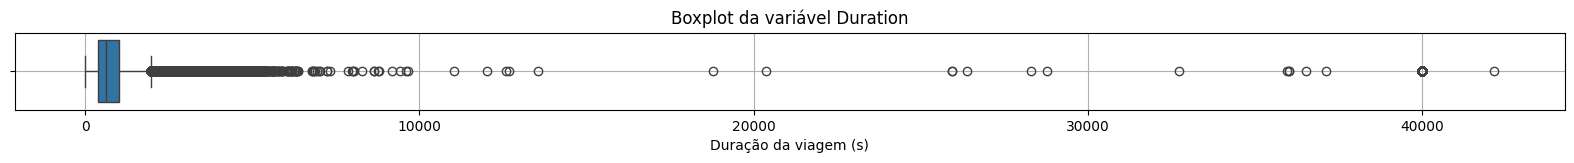

In [ ]:
# Explorando a distribuição da variável 'duration':
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 1))
sns.boxplot(x='duration', data=train_df)
plt.title('Boxplot da variável Duration')
plt.xlabel('Duração da viagem (s)')
plt.grid(True)
plt.show()

In [ ]:
# Há viagens com duração == 0?!
contagem = (train_df['duration'] == 0).sum()
print(contagem)

500


🚩 Uma viagem com deslocamento, mas duração == 0 também sugere algum ruído... Tais registros serão eliminados do conjunto. Além disso, tantos outliers nessa variável sugerem a necessidade de um tratamento apropriado.

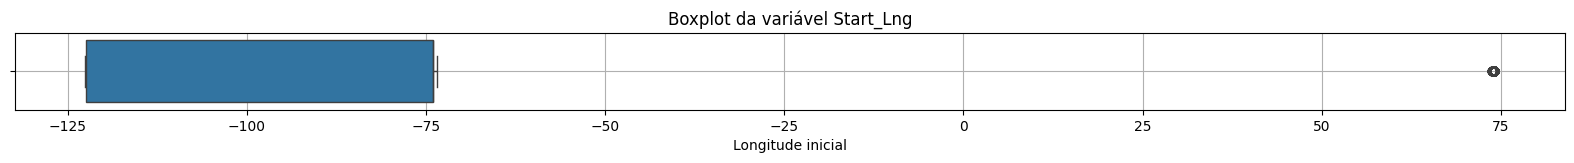

In [ ]:
# Explorando a distribuição da variável 'start_lng':
plt.figure(figsize=(20, 1))
sns.boxplot(x='start_lng', data=train_df)
plt.title('Boxplot da variável Start_Lng')
plt.xlabel('Longitude inicial')
plt.grid(True)
plt.show()

In [ ]:
# Há viagens cuja longitude inicial é positiva, embora a final seja negativa?!
contagem = (train_df['start_lng'] > 0).sum()
print(contagem)

1000


🚩 Alguns registros apresentam valores inconsistentes na variável `start_lng`, com longitudes negativas, enquanto `end_lng` indica localizações positivas — o que implicaria deslocamentos de mais de 10.000 km realizados em poucos minutos. Por se tratarem de erros evidentes de geolocalização, esses registros também serão excluídos do conjunto.

# **2. Data Preprocessing**

In [ ]:
# Eliminando os registros com valores nulos
train_df.dropna(subset=['start_lng', 'end_lat'], inplace=True)

print(f"Número de entradas após a remoção de nulos: {len(train_df)}")

Número de entradas após a remoção de nulos: 145001


In [ ]:
# Eliminando os registros com longitude inicial > 0
train_df = train_df[train_df['start_lng'] < 0]

print(f"Número de entradas após a remoção de longitudes positivas: {len(train_df)}")

Número de entradas após a remoção de longitudes positivas: 144001


In [ ]:
# Eliminando os registros com duração == 0
train_df = train_df[train_df['duration'] > 0]

print(f"Número de entradas após a remoção de viagens sem duração: {len(train_df)}")

Número de entradas após a remoção de viagens sem duração: 143501


In [ ]:
# Tratando os outliers da variável Duration:
Q1 = train_df['duration'].quantile(0.25)
Q3 = train_df['duration'].quantile(0.75)
IQR = Q3 - Q1

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

print(f"Limite superior via IQR: {limite_superior}")
print(f"Limite inferior via IQR: {limite_inferior}")

# Removendo os outliers
train_df = train_df[(train_df['duration'] >= limite_inferior) & (train_df['duration'] <= limite_superior)]

print(f"Número de entradas após a remoção de outliers: {len(train_df)}")

Limite superior via IQR: 1971.0
Limite inferior via IQR: -565.0
Número de entradas após a remoção de outliers: 135587


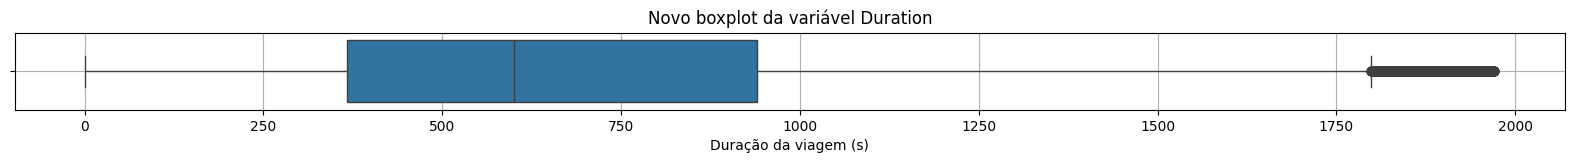

In [ ]:
# Explorando a nova distribuição da variável 'duration':
plt.figure(figsize=(20, 1))
sns.boxplot(x='duration', data=train_df)
plt.title('Novo boxplot da variável Duration')
plt.xlabel('Duração da viagem (s)')
plt.grid(True)
plt.show()

### 🌏 **Features Geográficas:**

* Distância entre origem e destino, através da biblioteca geopy.distance
* Pontos médios das viagens (pode representar a região geral da viagem)
* Velocidade média pode ser interessante? Avaliaremos.

In [ ]:
# pip install geopy

In [ ]:
# DISTÂNCIA ENTRE ORIGEM E DESTINO:

from geopy.distance import geodesic

# Função para calcular a distância geodésica da viagem:
def calculate_geopy_distance(row):
    point1 = (row['start_lat'], row['start_lng'])
    point2 = (row['end_lat'], row['end_lng'])
    return geodesic(point1, point2).km

# Aplicando ao DataFrame de treino e teste:
train_df['geopy_distance_km'] = train_df.apply(calculate_geopy_distance, axis=1)
test_df['geopy_distance_km'] = test_df.apply(calculate_geopy_distance, axis=1)

In [ ]:
# PONTO-MÉDIO DA VIAGEM:

train_df['mid_lat'] = (train_df['start_lat'] + train_df['end_lat']) / 2
train_df['mid_lng'] = (train_df['start_lng'] + train_df['end_lng']) / 2
test_df['mid_lat'] = (test_df['start_lat'] + test_df['end_lat']) / 2
test_df['mid_lng'] = (test_df['start_lng'] + test_df['end_lng']) / 2

In [ ]:
# Verificando as inclusões:
train_df.head(3)
#test_df.head(3)

,row_id,start_lng,start_lat,end_lng,end_lat,datetime,duration,geopy_distance_km,mid_lat,mid_lng
0,0,-73.783279,40.644718,-73.963799,40.681320,2015-01-09 00:51:48,1815.0,15.797026,40.663019,-73.873539
1,1,-122.422385,37.789408,-122.419890,37.766692,2012-09-14 01:46:00,300.0,2.530863,37.778050,-122.421138
3,3,-122.401603,37.788975,-122.410958,37.796447,2012-09-03 23:48:00,360.0,1.169077,37.792711,-122.406280


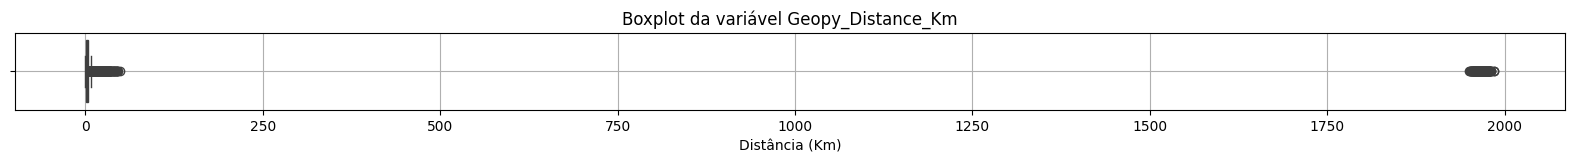

In [ ]:
# Explorando a distribuição da variável 'geopy_distance_km':
plt.figure(figsize=(20, 1))
sns.boxplot(x='geopy_distance_km', data=train_df)
plt.title('Boxplot da variável Geopy_Distance_Km')
plt.xlabel('Distância (Km)')
plt.grid(True)
plt.show()

In [ ]:
# Há viagens com deslocamento == 0?!
cont = (train_df['geopy_distance_km'] == 0).sum()
print(cont)

484


In [ ]:
# Há muitos outliers "absurdos"?
cont = (train_df['geopy_distance_km'] > 1800).sum()
print(cont)

2335


🚩 Nova necessidade de limpeza identificada: a variável calculada `geopy_distance_km` apresentou alguns valores iguais ou muito próximos de 0, sugerindo que viagens quase sem deslocamento (talvez canceladas no momento ou logo depois do embarque) estão sendo consideradas no conjunto. Outros registros com distâncias muito grandes, maiores que 1800 km, também indicam erros, já que a duração é muito curta, incompatível com o trajeto. Tais registros também serão eliminados.

In [ ]:
# Eliminando os registros com distância próxima de 0 (até 0.1 km) ou maior que 1800 km:
train_df = train_df[train_df['geopy_distance_km'] > 0.10]
train_df = train_df[train_df['geopy_distance_km'] < 1000]

print(f"Número de entradas após a remoção de outliers e de viagens com baixo deslocamento: {len(train_df)}")

Número de entradas após a remoção de outliers e de viagens com baixo deslocamento: 132258


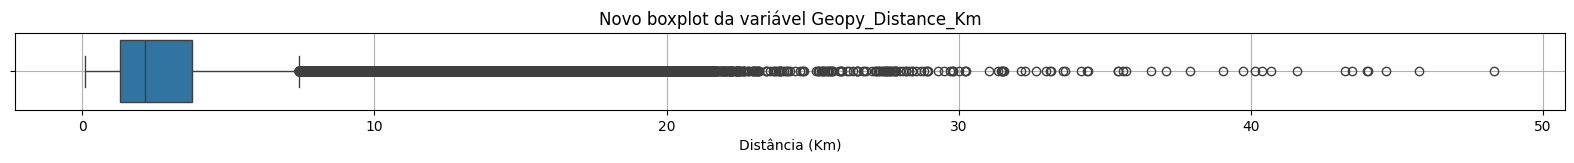

In [ ]:
# Explorando a nova distribuição da variável 'geopy_distance_km':
plt.figure(figsize=(20, 1))
sns.boxplot(x='geopy_distance_km', data=train_df)
plt.title('Novo boxplot da variável Geopy_Distance_Km')
plt.xlabel('Distância (Km)')
plt.grid(True)
plt.show()

🚩 Para refinar ainda mais a limpeza (já que uma vista superficial nos dados restantes ainda sugeriu algumas incongruências), será calculada a velocidade média como forma de identificar e eliminar esses registros anômalos.

🚩 Nota: talvez pudéssemos ter vindo direto para essa etapa, ao invés de tratar a distância e a duração individualmente, mas, a título didático (e porque as referidas etapas já estão prontas), o processo será mantido assim.

In [ ]:
# Calculando a velocidade média em km/h:
train_df['speed_kmh'] = train_df['geopy_distance_km'] / (train_df['duration'] / 3600)
train_df.head(3)

,row_id,start_lng,start_lat,end_lng,end_lat,datetime,duration,geopy_distance_km,mid_lat,mid_lng,speed_kmh
0,0,-73.783279,40.644718,-73.963799,40.681320,2015-01-09 00:51:48,1815.0,15.797026,40.663019,-73.873539,31.332945
1,1,-122.422385,37.789408,-122.419890,37.766692,2012-09-14 01:46:00,300.0,2.530863,37.778050,-122.421138,30.370360
3,3,-122.401603,37.788975,-122.410958,37.796447,2012-09-03 23:48:00,360.0,1.169077,37.792711,-122.406280,11.690775


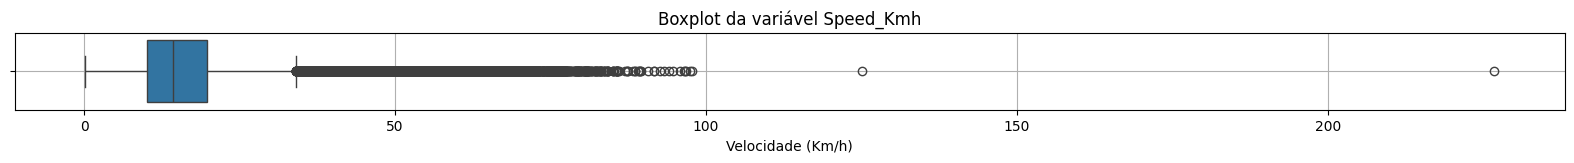

In [ ]:
# Explorando a distribuição da variável 'speed_kmh':
plt.figure(figsize=(20, 1))
sns.boxplot(x='speed_kmh', data=train_df)
plt.title('Boxplot da variável Speed_Kmh')
plt.xlabel('Velocidade (Km/h)')
plt.grid(True)
plt.show()

🚩 Nota: pelo método dos quartis, velocidades superiores a 34 km/h já seriam consideradas outliers. Por isso, com base na lógica e com a ajuda do boxplot, defini o limite superior de 100 km/h e o limite inferior de 5 km/h (já que valores muito baixos também indicam casos excepcionais, como, por exemplo, paradas muito longas) para tratamento dos outliers.

In [ ]:
# Eliminando os registros com velocidade menor que 5 km/h ou maior que 100 km/h:
train_df = train_df[(train_df['speed_kmh'] > 5) & (train_df['speed_kmh'] < 100)]

print(f"Número de entradas após a remoção de outliers: {len(train_df)}")

Número de entradas após a remoção de outliers: 128004


### 🕙 **Features Temporais:**

* A hora do dia ou o dia da semana impactam o tráfego?
* Meses tipicamente "de férias" mostram variações significativas?
* Os dados abrangem vários anos a fim de se identificar tendências? (...não)

In [ ]:
# Convertendo a coluna "datetime" para o tipo datetime do Pandas:
train_df['datetime'] = pd.to_datetime(train_df['datetime'])
test_df['datetime'] = pd.to_datetime(test_df['datetime'])

In [ ]:
def create_time_features(df):
    df['hour_of_day'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek # segunda=0, domingo=6
    df['month'] = df['datetime'].dt.month
    df['year'] = df['datetime'].dt.year
    df['is_weekend'] = (df['datetime'].dt.dayofweek >= 5).astype(int)
    df['minute_of_day'] = df['datetime'].dt.hour * 60 + df['datetime'].dt.minute
    return df

train_df = create_time_features(train_df)
test_df = create_time_features(test_df)

In [ ]:
# Verificando as inclusões:
train_df.head(3)

,row_id,start_lng,start_lat,end_lng,end_lat,datetime,duration,geopy_distance_km,mid_lat,mid_lng,speed_kmh,hour_of_day,day_of_week,month,year,is_weekend,minute_of_day
0,0,-73.783279,40.644718,-73.963799,40.681320,2015-01-09 00:51:48,1815.0,15.797026,40.663019,-73.873539,31.332945,0,4,1,2015,0,51
1,1,-122.422385,37.789408,-122.419890,37.766692,2012-09-14 01:46:00,300.0,2.530863,37.778050,-122.421138,30.370360,1,4,9,2012,0,106
3,3,-122.401603,37.788975,-122.410958,37.796447,2012-09-03 23:48:00,360.0,1.169077,37.792711,-122.406280,11.690775,23,0,9,2012,0,1428


# **3. Definição das features e da variável-alvo**

In [ ]:
# Definindo as features:
features = [
    'start_lng', 'start_lat', 'end_lng', 'end_lat', 'mid_lng', 'mid_lat', 'geopy_distance_km',
    'year', 'month', 'day_of_week', 'is_weekend', 'hour_of_day', 'minute_of_day'
]

In [ ]:
# Separando features (X) e variável-alvo (y)
X = train_df[features]
y = train_df['duration']

# **4. Experimentação de modelos**

In [ ]:
# Divisão do conjunto de treinamento em treino (80%) e teste (20%)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## **a) Regressão Linear**

Modelo mais simples, mas mais interpretável. Comecei com ele como baseline para entender o desempenho mínimo esperado e a natureza das relações lineares nos dados. Conforme esperado, sua performance foi inferior aos modelos baseados em árvores, indicando a presença de interações não-lineares importantes.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

lr_model = LinearRegression()
lr_model.fit(X, y)

y_pred_lr = lr_model.predict(X_test)

# Avaliação
mae_lr = mean_absolute_error(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression:")
print(f"MAE: {mae_lr:.2f}")
print(f"RMSE: {rmse_lr:.2f}")
print(f"R²: {r2_lr:.2f}")


Linear Regression:
MAE: 232.66
RMSE: 302.63
R²: 0.48


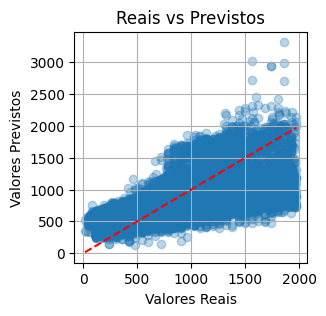

In [ ]:
# Confirmação visual da performance do modelo de regressão linear
plt.figure(figsize=(3,3))
plt.scatter(y_test, y_pred_lr, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previstos')
plt.title('Reais vs Previstos')
plt.grid(True)
plt.show()

🚩 O modelo erra a previsão da duração da viagem, em média, em 233 segundos (**3.9 minutos**). O RMSE, que penaliza mais fortemente os grandes erros, é de aproximadamente 303 segundos (**5 minutos**). Já o coeficiente de determinação (R²) indica que o modelo explica **48%** da variação da duração das viagens.

Um modelo que considere possíveis interações não-lineares, testado a seguir, talvez mostre um desempenho melhor.

## **b) Random Forest**

Em seguida, explorei o Random Forest Regressor, modelo ensemble baseado em árvores. Embora tenha demonstrado performance muito superior à regressão linear, o XGBoost ainda o superou nas métricas de validação, como mostrado na sequência.


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

# Avaliação
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest:")
print(f"MAE: {mae_rf:.2f}")
print(f"RMSE: {rmse_rf:.2f}")
print(f"R²: {r2_rf:.2f}")

Random Forest:
MAE: 144.42
RMSE: 196.19
R²: 0.78


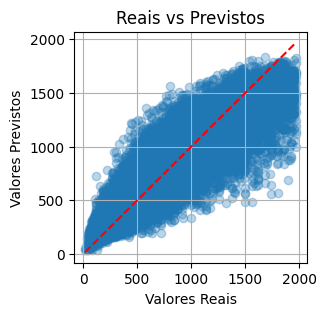

In [ ]:
# Confirmação visual da performance do modelo de random forest
plt.figure(figsize=(3,3))
plt.scatter(y_test, y_pred_rf, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previstos')
plt.title('Reais vs Previstos')
plt.grid(True)
plt.show()

🚩 O modelo Random Forest apresentou desempenho significativamente superior em relação à regressão linear. O erro absoluto médio caiu para 144 segundos (**2.4 minutos**), enquanto o RMSE caiu para 196 segundos (**3.3 minutos**). O coeficiente de determinação indica que o modelo agora consegue explicar **78%** da variação na duração das viagens.

## **c) XGBoost**

Depois de estabelecer um baseline com modelos mais simples como Regressão Linear e Random Forest, experimentei XGBoost por ser um algoritmo de boosting com ótimo desempenho em dados tabulares (que aqui nem exigiu ajustes finos).

In [ ]:
# !pip install xgboost

In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Instancia o modelo com parâmetros básicos (pode melhorar depois com ajuste fino)
xgb_model = XGBRegressor(random_state=42)

# Treina o modelo
xgb_model.fit(X_train, y_train)

# Faz previsões
y_pred_xgb = xgb_model.predict(X_test)

# Avaliação
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost:")
print(f"MAE: {mae_xgb:.2f}")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"R²: {r2_xgb:.2f}")

XGBoost:
MAE: 137.65
RMSE: 188.51
R²: 0.80


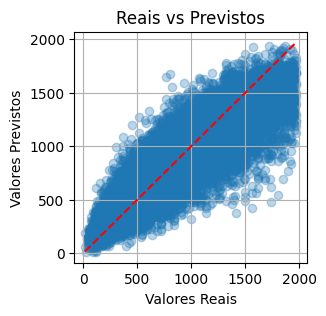

In [ ]:
# Confirmação visual da performance do modelo de XGB:
plt.figure(figsize=(3,3))
plt.scatter(y_test, y_pred_xgb, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previstos')
plt.title('Reais vs Previstos')
plt.grid(True)
plt.show()

🚩 O modelo XGBoost se mostrou ainda superior ao random forest. O erro absoluto médio caiu para 138 segundos (**2.3 minutos**), enquanto o RMSE caiu para 188 segundos (**3.1 minutos**). O coeficiente de determinação indica que o modelo agora consegue explicar **80%** da variação na duração das viagens.

# **5. Aplicação do modelo escolhido (XGBoost)**

In [ ]:
test_df.head(3)

,row_id,start_lng,start_lat,end_lng,end_lat,datetime,geopy_distance_km,mid_lat,mid_lng,hour_of_day,day_of_week,month,year,is_weekend,minute_of_day
0,0,-74.001488,40.726170,-73.962097,40.764500,2015-06-27 23:58:40,5.402413,40.745335,-73.981792,23,5,6,2015,1,1438
1,1,-122.454077,37.774170,-122.428070,37.777023,2012-09-10 01:32:00,2.312981,37.775596,-122.441074,1,0,9,2012,0,92
2,2,-73.976753,40.751575,-73.789917,40.646965,2015-09-26 11:24:54,19.603442,40.699270,-73.883335,11,5,9,2015,1,684


In [ ]:
# Prevendo a duração do conjunto de teste com o modelo:
X_test_df = test_df[features]
y_pred = xgb_model.predict(X_test_df)

# **6. Criação do arquivo de resultados e Exportação do modelo**

🚩 No Kaggle, o resultado submetido através das etapas percorridas e valores aplicados neste notebook alcançou um RMSE (no score privado) de **380**.

In [ ]:
# Montando o arquivo com os resultados para submissão:
submission = pd.DataFrame({
    'row_id': test_df['row_id'],
    'duration': y_pred
})

submission.to_csv('submission.csv', index=False)

In [ ]:
# Exportando o modelo treinado como um arquivo .joblib
import joblib

joblib.dump(xgb_model, 'xgboost_model.joblib')

['xgboost_model.joblib']

# 🚚 **Fase 2: Protótipo Matrix**

In [ ]:
# !pip install openrouteservice folium

In [ ]:
import openrouteservice
from openrouteservice import convert
import folium
from datetime import datetime, timedelta
import time

xgb_model = joblib.load("xgboost_model.joblib")

In [ ]:
# Definindo coordenadas Uberlândia → Curitiba no formato (longitude, latitude)
start_coords = [-48.2754, -18.9146]  # Uberlândia
end_coords = [-49.2733, -25.4284]    # Curitiba

In [ ]:
# Simulando 10 checkpoints entre as duas cidades
# n_points = 10
# latitudes = np.linspace(start_coords[0], end_coords[0], n_points)
# longitudes = np.linspace(start_coords[1], end_coords[1], n_points)

🚩 Inicialmente, criei um protótipo que usava o cálculo geodésico entre duas coordenadas para estabelecer checkpoints intermediários (linha acima). Depois, prefiri aproxima-lo mais da realidade com o uso de uma API que fornece a rota real (OpenRouteService, nesse caso).

In [ ]:
# Usando OpenRouteService API para calcular rota e estabelecer os checkpoints:
api_key = "eyJvcmciOiI1YjNjZTM1OTc4NTExMTAwMDFjZjYyNDgiLCJpZCI6IjEyMGU5MTVjY2UzNTQ0ZGE5M2EyZWZiNzE0Yzk1NDRiIiwiaCI6Im11cm11cjY0In0="
client = openrouteservice.Client(key=api_key)

# Solicitando rota por carro
route = client.directions(
    coordinates=[start_coords, end_coords],
    profile='driving-car',
    format='geojson'
)

real_distance_km = route['features'][0]['properties']['summary']['distance'] / 1000 # metros pra km
real_duration_min = route['features'][0]['properties']['summary']['duration'] / 3600 # seg pra h

print(f"Distância real da rota: {real_distance_km:.2f} km")
print(f"Duração estimada pela ORS: {real_duration_min:.2f} h")

Distância real da rota: 968.35 km
Duração estimada pela ORS: 11.25 h


In [ ]:
# Extraindo lista de checkpoints a cada ~50 km
coords = route['features'][0]['geometry']['coordinates']
coords = [(lat, lon) for lon, lat in coords]  # Convertendo para (lat, lon)

checkpoints = [coords[0]]
dist_threshold = 50  # em km
accum_dist = 0.0

for i in range(1, len(coords)):
    dist = geodesic(coords[i - 1], coords[i]).km
    accum_dist += dist
    if accum_dist >= dist_threshold:
        checkpoints.append(coords[i])
        accum_dist = 0.0

checkpoints.append(coords[-1])  # Garante o destino

# Criando mapa com a rota
midpoint = [(start_coords[1] + end_coords[1]) / 2, (start_coords[0] + end_coords[0]) / 2]
m = folium.Map(location=midpoint, zoom_start=6)
folium.GeoJson(route, name='route').add_to(m)

for idx, checkpoint in enumerate(checkpoints):
    folium.Marker(
        location=checkpoint,
        icon=folium.Icon(color='blue', icon='flag'),
        tooltip=f"Checkpoint {idx + 1}"
    ).add_to(m)

folium.Marker(location=[start_coords[1], start_coords[0]], tooltip='Uberlândia (Início)', icon=folium.Icon(color='green')).add_to(m)
folium.Marker(location=[end_coords[1], end_coords[0]], tooltip='Curitiba (Fim)', icon=folium.Icon(color='red')).add_to(m)

# Salvando em HTML
m.save("mapa_checkpoint.html")

In [ ]:
# Função pra gerar as features do modelo (por checkpoint):
def generate_features(checkpoints, start_time):
    features = []
    current_time = start_time
    total_time = 0
    avg_speed_kmh = 80

    for i in range(len(checkpoints) - 1):
      start = checkpoints[i]
      end = checkpoints[i+1]

      geopy_distance_km = geodesic(start, end).km
      time_hours = geopy_distance_km / avg_speed_kmh
      travel_minutes = time_hours * 60
      current_time += timedelta(minutes=float(travel_minutes))
      total_time += travel_minutes

      feat = {
        'start_lng': start[1],
        'start_lat': start[0],
        'end_lng': end[1],
        'end_lat': end[0],
        'mid_lng': (start[1] + end[1]) / 2,
        'mid_lat': (start[0] + end[0]) / 2,
        'geopy_distance_km': geopy_distance_km,
        'year': current_time.year,
        'month': current_time.month,
        'day_of_week': current_time.weekday(),
        'is_weekend': int(current_time.weekday() >= 5),
        'hour_of_day': current_time.hour,
        'minute_of_day': current_time.hour * 60 + current_time.minute,
      }

      features.append(feat)

    return pd.DataFrame(features)

In [ ]:
# Gerando as features e carregando o modelo
start_time = datetime.now()

df_features = generate_features(checkpoints, start_time)

X = df_features[['start_lng', 'start_lat', 'end_lng', 'end_lat', 'mid_lng', 'mid_lat', 'geopy_distance_km', 'year', 'month', 'day_of_week', 'is_weekend', 'hour_of_day', 'minute_of_day' ]]

y_pred = xgb_model.predict(X)

In [ ]:
# Exibindo ETA pra cada checkpoint
current_time = start_time
total_pred_seconds = y_pred.sum()
total_pred_hours = total_pred_seconds / 3600
arrival_time = start_time + timedelta(seconds=float(total_pred_seconds))

print(f"🚚 Início da viagem: {start_time.strftime('%d/%m/%Y %H:%M')}")
print(f"🚚 Horário estimado de chegada: {arrival_time.strftime('%d/%m/%Y %H:%M')}")
print(f"🚚 Previsão de duração total: {total_pred_hours:.2f} horas\n")

print("==== ETA por checkpoint ====\n")

for i, (checkpoint, pred_sec) in enumerate(zip(checkpoints[1:], y_pred), start=1):  # começa do segundo ponto
    current_time += timedelta(seconds=float(pred_sec))
    print(f"Checkpoint {i}/{len(checkpoints) - 1}")
    print(f" 📍 Coordenadas: lat={checkpoint[0]:.4f}, lon={checkpoint[1]:.4f}")
    print(f" ⏱️ ETA: {current_time.strftime('%d/%m/%Y %H:%M')}\n")

    time.sleep(0.5)

print("\n✅ Viagem concluída.")

🚚 Início da viagem: 25/07/2025 19:17
🚚 Horário estimado de chegada: 26/07/2025 04:41
🚚 Previsão de duração total: 9.39 horas

==== ETA por checkpoint ====

Checkpoint 1/20
 📍 Coordenadas: lat=-19.3137, lon=-48.1079
 ⏱️ ETA: 25/07/2025 19:50

Checkpoint 2/20
 📍 Coordenadas: lat=-19.7421, lon=-47.9841
 ⏱️ ETA: 25/07/2025 20:23

Checkpoint 3/20
 📍 Coordenadas: lat=-20.1086, lon=-47.7909
 ⏱️ ETA: 25/07/2025 20:56

Checkpoint 4/20
 📍 Coordenadas: lat=-20.5454, lon=-47.8565
 ⏱️ ETA: 25/07/2025 21:29

Checkpoint 5/20
 📍 Coordenadas: lat=-20.9841, lon=-47.8587
 ⏱️ ETA: 25/07/2025 22:01

Checkpoint 6/20
 📍 Coordenadas: lat=-21.3931, lon=-47.6935
 ⏱️ ETA: 25/07/2025 22:30

Checkpoint 7/20
 📍 Coordenadas: lat=-21.7911, lon=-47.5191
 ⏱️ ETA: 25/07/2025 22:58

Checkpoint 8/20
 📍 Coordenadas: lat=-22.2217, lon=-47.3921
 ⏱️ ETA: 25/07/2025 23:25

Checkpoint 9/20
 📍 Coordenadas: lat=-22.6489, lon=-47.3257
 ⏱️ ETA: 25/07/2025 23:53

Checkpoint 10/20
 📍 Coordenadas: lat=-23.0100, lon=-47.0914
 ⏱️ ETA: 2